# Automatic Expectations

# 1. Imports

In [77]:
import great_expectations as ge

import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
%matplotlib inline

# 2. Import Data & Transformations

In [78]:
df_train = ge.read_csv("../data/FAO-Rice-Production-Asia.csv")

#Adding random NaN values to dataset: 
nan_mat = np.random.random(df_train.shape)<0.5
df_train_NaN = df_train.mask(nan_mat)
df_train_NaN.head()

#Adding unique id column
df_train = df_train_NaN.assign(id=[i for i in range(len(df_train))])[['id'] + df_train.columns.tolist()]


In [79]:
df_train.head()

,id,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,0,NaN,Crops,2.00,Afghanistan,nan,NaN,27.00,NaN,nan,1961.00,hg/ha,15190.00,NaN,NaN
1,1,NaN,NaN,nan,NaN,5419.00,Yield,27.00,"Rice, paddy",nan,nan,hg/ha,nan,Fc,NaN
2,2,QC,NaN,nan,Afghanistan,5419.00,Yield,nan,"Rice, paddy",1963.00,1963.00,NaN,15190.00,NaN,Calculated data
3,3,QC,NaN,2.00,NaN,nan,NaN,nan,NaN,1964.00,1964.00,NaN,nan,NaN,NaN
4,4,QC,NaN,nan,NaN,5419.00,NaN,27.00,"Rice, paddy",1965.00,1965.00,hg/ha,17273.00,NaN,NaN


# 3. Setting the Expectations

## 3.1 Setting Expected Accuracy Margin Variables

In [80]:
#Null category:
expected_accuracy_in_not_nulls_perc=10

#Volume category:
expected_row_count_window_perc=10

#Stats category:
expected_accuracy_in_stats_perc=10

## 3.2 Column Name & Order & Type Expectations

In [81]:
column_names=list(df_train.columns)
column_names

['id',
 'Domain Code',
 'Domain',
 'Area Code',
 'Area',
 'Element Code',
 'Element',
 'Item Code',
 'Item',
 'Year Code',
 'Year',
 'Unit',
 'Value',
 'Flag',
 'Flag Description']

In [82]:
df_train.expect_table_columns_to_match_ordered_list(column_names)

{'success': True,
 'result': {'observed_value': ['id',
   'Domain Code',
   'Domain',
   'Area Code',
   'Area',
   'Element Code',
   'Element',
   'Item Code',
   'Item',
   'Year Code',
   'Year',
   'Unit',
   'Value',
   'Flag',
   'Flag Description']}}

In [83]:
#Checking the column types
column_types=df_train.dtypes
print(column_types)

for column_name, column_type in column_types.items():
    df_train.expect_column_values_to_be_of_type(column_name, str(column_type))

id                    int64
Domain Code          object
Domain               object
Area Code           float64
Area                 object
Element Code        float64
Element              object
Item Code           float64
Item                 object
Year Code           float64
Year                float64
Unit                 object
Value               float64
Flag                 object
Flag Description     object
dtype: object


## 3.3 Null Expectations

In [84]:
expecting_no_changes_column_names = ['id']

In [85]:
#Getting the not null fractions per column
not_null_fraction_dict=(((df_train.isnull() == False)&(df_train.isna() == False)).sum()
                        /df_train.index.size).round(2)

In [86]:
#Current State
print(not_null_fraction_dict)

id                 1.00
Domain Code        0.51
Domain             0.50
Area Code          0.48
Area               0.49
Element Code       0.50
Element            0.51
Item Code          0.51
Item               0.50
Year Code          0.49
Year               0.50
Unit               0.49
Value              0.49
Flag               0.49
Flag Description   0.48
dtype: float64


In [87]:
#Setting up expected null fractions per column
for key, value in not_null_fraction_dict.items():
    if key not in expecting_no_changes_column_names:
        not_null_fraction_dict[key] = value-(value*expected_accuracy_in_not_nulls_perc/100)

In [88]:
#Expected State
not_null_fraction_dict

id                 1.00
Domain Code        0.46
Domain             0.45
Area Code          0.43
Area               0.44
Element Code       0.45
Element            0.46
Item Code          0.46
Item               0.45
Year Code          0.44
Year               0.45
Unit               0.44
Value              0.44
Flag               0.44
Flag Description   0.43
dtype: float64

In [89]:
#Setting up NOT NULL expectations: 
for column_name, expected_not_null_fraction in not_null_fraction_dict.items():
    df_train.expect_column_values_to_not_be_null(column_name, 
                                                            mostly=expected_not_null_fraction)

## 3.4 Volume Expectations

In [90]:
def get_high_end(value, perc):
    if value < 0:
        return value-(value*perc/100)
    else:
        return value+(value*perc/100)

In [91]:
def get_low_end(value, perc):
    if value < 0:
        return value+(value*perc/100)
    else:
        return value-(value*perc/100)

In [92]:
def get_value_range(value, perc):
    return (get_low_end(value, perc), get_high_end(value, perc))

In [93]:
row_count=len(df_train)
row_count

1591

In [94]:
value_range = get_value_range(row_count, expected_row_count_window_perc)
print(value_range)
df_train.expect_table_row_count_to_be_between(int(value_range[0]), int(value_range[1]))

(1431.9, 1750.1)


{'success': True, 'result': {'observed_value': 1591}}

## 3.5 Numerical Column Stats Expectations

In [95]:
#Get all numberical columns of the training report
numerical_columns = df_train.columns[(df_train.dtypes.values == np.dtype('float64'))]

In [96]:
#Get stats of numerical columns
min_values=df_train[numerical_columns].min().dropna()
max_values=df_train[numerical_columns].max().dropna()
mean_values=df_train[numerical_columns].mean().dropna()
median_values=df_train[numerical_columns].median().dropna()

In [97]:
print('MIN')
print(min_values)
print('MAX')
print(max_values)
print('MEAN')
print(mean_values)
print('MEDIAN')
print(median_values)

MIN
Area Code         2.00
Element Code   5419.00
Item Code        27.00
Year Code      1961.00
Year           1961.00
Value          5263.00
dtype: float64
MAX
Area Code         237.00
Element Code     5419.00
Item Code          27.00
Year Code        2014.00
Year             2014.00
Value          101765.00
dtype: float64
MEAN
Area Code        117.54
Element Code    5419.00
Item Code         27.00
Year Code       1987.60
Year            1987.80
Value          30580.09
dtype: float64
MEDIAN
Area Code        115.00
Element Code    5419.00
Item Code         27.00
Year Code       1988.00
Year            1989.00
Value          27148.50
dtype: float64


In [98]:
#Setting up stats expectations:

#Min-Max
print('MIN-MAX')
for column_name, min_value in min_values.items():
    expected_min_value=get_low_end(min_value, expected_accuracy_in_stats_perc)
    expected_max_value=get_high_end(max_values[column_name], expected_accuracy_in_stats_perc)
    print(column_name, expected_min_value, expected_max_value)
    
    df_train.expect_column_values_to_be_between(column_name, 
                                                           expected_min_value,
                                                           expected_max_value)
    
#Mean
print('MEAN')
for column_name, mean_value in mean_values.items():
    value_range=get_value_range(mean_value, expected_accuracy_in_stats_perc)
    print(column_name, value_range[0], value_range[1])
    
    df_train.expect_column_mean_to_be_between(column_name, 
                                                         min_value=value_range[0],
                                                         max_value=value_range[1])
  
#Median
print('MEDIAN')
for column_name, median_value in median_values.items():
    value_range=get_value_range(median_value, expected_accuracy_in_stats_perc)
    print(column_name, value_range[0], value_range[1])
    
    df_train.expect_column_median_to_be_between(column_name, 
                                                         min_value=value_range[0],
                                                         max_value=value_range[1])
   

MIN-MAX
Area Code 1.8 260.7
Element Code 4877.1 5960.9
Item Code 24.3 29.7
Year Code 1764.9 2215.4
Year 1764.9 2215.4
Value 4736.7 111941.5
MEAN
Area Code 105.78974025974026 129.29857142857142
Element Code 4877.1 5960.9
Item Code 24.3 29.7
Year Code 1788.8413793103448 2186.3616858237547
Year 1789.0231939163498 2186.5839036755387
Value 27522.08358778626 33638.10216284987
MEDIAN
Area Code 103.5 126.5
Element Code 4877.1 5960.9
Item Code 24.3 29.7
Year Code 1789.2 2186.8
Year 1790.1 2187.9
Value 24433.65 29863.35


## 3.6 Miscellaneous

In [99]:
df_train.expect_column_values_to_be_unique('id')

{'success': True,
 'result': {'element_count': 1591,
  'missing_count': 0,
  'missing_percent': 0.0,
  'unexpected_count': 0,
  'unexpected_percent': 0.0,
  'unexpected_percent_nonmissing': 0.0,
  'partial_unexpected_list': []}}

## 3.7 Distributional Expectations

(array([ 90.,  72.,  71.,  85.,  63.,  70., 101.,  74.,  70.,  93.]),
 array([1961. , 1966.3, 1971.6, 1976.9, 1982.2, 1987.5, 1992.8, 1998.1,
        2003.4, 2008.7, 2014. ]),
 <a list of 10 Patch objects>)

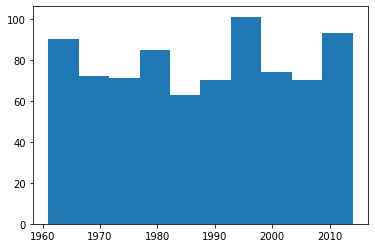

In [100]:
plt.hist(df_train['Year'])

In [101]:
#Setting up categorical distribution expectation for Year
property_type_partition=ge.dataset.util.categorical_partition_data(df_train['Year'])
df_train.expect_column_chisquare_test_p_value_to_be_greater_than('Year', property_type_partition)

{'success': True,
 'result': {'observed_value': 1.0,
  'element_count': 1591,
  'missing_count': 802,
  'missing_percent': 50.40854808296669}}

## 3.8 Exporting & Saving the Expectations

In [102]:
df_train.get_expectation_suite()

{'data_asset_name': None,
 'expectation_suite_name': 'default',
 'meta': {'great_expectations.__version__': '0.8.5'},
 'expectations': [{'expectation_type': 'expect_table_columns_to_match_ordered_list',
   'kwargs': {'column_list': ['id',
     'Domain Code',
     'Domain',
     'Area Code',
     'Area',
     'Element Code',
     'Element',
     'Item Code',
     'Item',
     'Year Code',
     'Year',
     'Unit',
     'Value',
     'Flag',
     'Flag Description']}},
  {'expectation_type': 'expect_column_values_to_be_of_type',
   'kwargs': {'column': 'id', 'type_': 'int64'}},
  {'expectation_type': 'expect_column_values_to_be_of_type',
   'kwargs': {'column': 'Domain Code', 'type_': 'object'}},
  {'expectation_type': 'expect_column_values_to_be_of_type',
   'kwargs': {'column': 'Domain', 'type_': 'object'}},
  {'expectation_type': 'expect_column_values_to_be_of_type',
   'kwargs': {'column': 'Area Code', 'type_': 'float64'}},
  {'expectation_type': 'expect_column_values_to_be_of_type',

In [103]:
#df_train.save_expectation_suite("../expectations/automatic.expectations.json")